# Deep Neural Network on Pytorch

## Stage 1: We load the data and required libraries.

In [1]:
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
from sklearn.datasets import fetch_california_housing

# Loading the housing dataset
# https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://www.kaggle.com/datasets/yasserh/housing-prices-dataset&ved=2ahUKEwif68L9tM-FAxXJRDABHTkTBdoQFnoECA4QAQ&usg=AOvVaw2i7OT73QCohtyOPVMpGmTk
data = fetch_california_housing()
print(data.feature_names)

X, y = data.data, data.target

['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


In [3]:
# We generate the train and test data

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
y_train, y_test = y_train.reshape(-1,1), y_test.reshape(-1,1)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(14448, 8) (14448, 1)
(6192, 8) (6192, 1)


In [4]:
from sklearn.preprocessing import StandardScaler

# We scale the data to favor the model training.
scalerX = StandardScaler()
X_train = scalerX.fit_transform(X_train)
X_test = scalerX.transform(X_test)

In [5]:
import numpy as np
np.std(X_train, axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1.])

In [6]:
# Converting the train and test data into tensors

X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()

In [7]:
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test.reshape(-1,1)).float()

In [8]:
# Just for this introductory example, we use the batchsize equal to the number
# samples in the training set. However, the idea is to use a small value for this
# parameter (typically 32)
batch_size = 14448

datasets = torch.utils.data.TensorDataset(X_train, y_train)
train_iter = torch.utils.data.DataLoader(datasets, batch_size=batch_size, shuffle=True)

In [27]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
# device = "cpu"
print(f"Using {device} device")

Using mps device


## Stage 2: Deep Neural Network definiton.

Now, we start to build the DNN to solve the regression task. In pythorch, we can define the neuronal by means of the sequential API https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html

### 2.1 Model Definition.

We define a network with 3 layers: 2 hidden layers and an output layer. We use dense layers defined as "linear". In the next units we'll use more elaborated layers such as convolutional and recurrent layers.

In [28]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            # The first hidden layer with 32 units. Note that we should indicate the
            # number of inputs.
            nn.Linear(X_train.shape[1], 32), # 8 inputs 
            # We use a ReLU as activation function.
            nn.ReLU(),
            # The size of the second layer is 32x16, this indicates that our layer
            # has 16 units. Also, note that the 32 is equal to the units' number of }
            # previous layer.
            nn.Linear(32, 16),
            # We also use a ReLU as activation function.
            nn.ReLU(),
            # The output layer has a single neuron due to we are facing a regression
            # task
            nn.Linear(16, 1),
            # It is a regression task, so we don't need any activation function
            # in the output layer.
        )

    def forward(self, x):
        # This method is used to compute the output given a particular input x.
        out = self.linear_relu_stack(x)
        return out


In [29]:
# Initialize the DNN model.
# Caution: Before you run the training loop, you should initialize the model
model = NeuralNetwork()

In [30]:
# Model Hyperparameters
learning_rate = 0.05
epochs = 100 # think this as the number of iterations. Then we'll explore this
             # deeply.

## Stage 3: Training Loop

In [31]:
# Initialize the loss function. We use a MSE loss function since we are dealing
# with a regression task. Look this page for more
# https://pytorch.org/docs/stable/nn.html#loss-functions

loss_fn = nn.MSELoss() # Mean Squared Error Loss Function

# what other loss functions can we use?
# https://pytorch.org/docs/stable/nn.html#loss-functions

In [32]:
# We define the optimizer (to perform Gradient Descent). We use the Stocastic
# gradient descent optimizer (SGD). However, when you use a SGD with
# batch_size=trainin set, then you are really performing a Gradient Descent

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [33]:
# print time
import time
start_time = time.time()

loss_tr = []
loss_te = []
for epoch in range(epochs):
  for x, y in train_iter:
    # Make predictions
    y_pred = model(x)
    # Compute the loss of current predictions
    loss = loss_fn(y_pred, y)
    # Clean the gradients
    optimizer.zero_grad()
    # Perform backpropagation
    loss.backward()
    # update weights
    optimizer.step()
    # Storing the training and test losses
    loss_tr.append(loss.item())
    loss_test = loss_fn(model(X_test), y_test).item()
    loss_te.append(loss_test)
  print("epoch {} loss: {:.4f} test_loss: {:.4f}".format(epoch + 1,loss.item(),loss_test))

end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")


epoch 1 loss: 5.3161 test_loss: 4.3083
epoch 2 loss: 4.1758 test_loss: 3.5389
epoch 3 loss: 3.4216 test_loss: 2.9499
epoch 4 loss: 2.8476 test_loss: 2.4788
epoch 5 loss: 2.3925 test_loss: 2.0973
epoch 6 loss: 2.0284 test_loss: 1.7938
epoch 7 loss: 1.7432 test_loss: 1.5611
epoch 8 loss: 1.5287 test_loss: 1.3900
epoch 9 loss: 1.3740 test_loss: 1.2675
epoch 10 loss: 1.2645 test_loss: 1.1792
epoch 11 loss: 1.1853 test_loss: 1.1130
epoch 12 loss: 1.1243 test_loss: 1.0604
epoch 13 loss: 1.0738 test_loss: 1.0161
epoch 14 loss: 1.0296 test_loss: 0.9772
epoch 15 loss: 0.9893 test_loss: 0.9422
epoch 16 loss: 0.9522 test_loss: 0.9102
epoch 17 loss: 0.9176 test_loss: 0.8810
epoch 18 loss: 0.8856 test_loss: 0.8543
epoch 19 loss: 0.8561 test_loss: 0.8300
epoch 20 loss: 0.8289 test_loss: 0.8080
epoch 21 loss: 0.8042 test_loss: 0.7881
epoch 22 loss: 0.7817 test_loss: 0.7704
epoch 23 loss: 0.7615 test_loss: 0.7545
epoch 24 loss: 0.7433 test_loss: 0.7403
epoch 25 loss: 0.7272 test_loss: 0.7278
epoch 26 

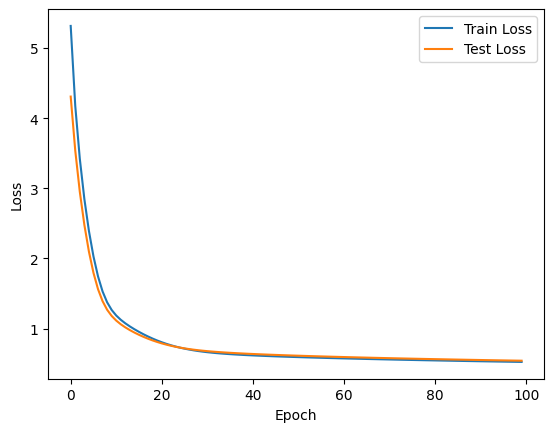

In [34]:
# Plot the losses for the train and test sets
plt.plot(loss_tr, label='Train Loss')
plt.plot(loss_te, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [45]:
# Make a prediction for new data
id = np.random.randint(0, X_test.shape[0])
print(model(X_test[id]).data, y_test[id])


tensor([2.6395]) tensor([1.8380])


## Fin del programa